Experiment Explanation

CONTEXT: We have a Question Answering service.

GOAL: Set of Question's topics 

HOW TO: We get a set of questions and clasify it by LDA model.

We can use this approach to clasify 'Sorry' answers to understand what topics shuld be added to QA context.  

In [1]:
#packedges
!pip install pyLDAvis
!pip install psycopg2
!pip install gensim

import psycopg2
from psycopg2 import sql
from gensim import corpora, models
from gensim.parsing.preprocessing import preprocess_string
import pyLDAvis
import pyLDAvis.gensim

In [2]:
#Connect to the PostgreSQL database
import numpy as np

db_config = {
        'host': os.environ.get('DB_HOST'),
        'database': os.environ.get('DB_NAME'),
        'user': os.environ.get('DB_USER'),
        'password': os.environ.get('DB_PASSWORD'),
        'port': os.environ.get('DB_PORT')
    }

#SQL query
query = sql.SQL("SELECT ID, Question FROM Feedback_View WHERE Question NOT IN ('Hello', 'hello', 'how are you?', 'Hey');")

connection = psycopg2.connect(**db_config)

# Execute the query
cursor = connection.cursor()
cursor.execute(query)

#get the result as a list of tuples
result = cursor.fetchall() 
cursor.close()
connection.close()

# Convert the list of tuples to a NumPy array
# Contents ID & Question from Feedback_View query
query_result = np.array(result)

In [14]:
# Tokenize and preprocess questions using gensim build-in method
queried_questions = query_result[:, 1]
preprocessed_questions = [' '.join(preprocess_string(str)) for str in queried_questions]

In [15]:
# train the LDA 

# build a corpus
corpus = [d.split() for d in preprocessed_questions]
dictionary = corpora.Dictionary(corpus)

# create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in corpus] 

# train the LDA model on the corpus
lda_model = models.LdaModel(corpus=corpus, num_topics=3, id2word=dictionary)
for topic in lda_model.print_topics():
    print(topic)

(0, '0.061*"student" + 0.046*"epic" + 0.028*"truanci" + 0.021*"cours" + 0.021*"inform" + 0.021*"bonu" + 0.021*"potenti" + 0.017*"test" + 0.016*"teacher" + 0.016*"grade"')
(1, '0.060*"test" + 0.055*"star" + 0.021*"literaci" + 0.021*"earli" + 0.021*"grade" + 0.019*"tiva" + 0.018*"student" + 0.017*"benchmark" + 0.016*"requir" + 0.016*"assign"')
(2, '0.050*"student" + 0.034*"benchmark" + 0.034*"window" + 0.024*"tiva" + 0.021*"process" + 0.021*"stand" + 0.020*"rsa" + 0.016*"mileag" + 0.015*"need" + 0.015*"support"')


In [16]:
# Train LDA
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
pyLDAvis.enable_notebook()
vis = pyLDAvis.display(lda_display)
vis

In [17]:
# now classify the questions
import numpy as np

clasifyed_questions = np.empty((0, 2)) #topic & probability of a question

for i, text in enumerate(preprocessed_questions):
    # Convert the text to bag-of-words representation
    text_bow = dictionary.doc2bow(text.split())

    # Get the topic distribution for the current text
    topic_distribution = lda_model.get_document_topics(text_bow)

    # Find the dominant topic
    dominant_topic = max(topic_distribution, key=lambda x: x[1])

    question_topic = int(dominant_topic[0])

    # Convert the tuple to a NumPy array and reshape it to match the existing array
    new_row = np.array(dominant_topic)
    clasifyed_questions = np.vstack((clasifyed_questions, new_row))

# Round:
clasifyed_questions[:, 1] = np.round(clasifyed_questions[:, 1], decimals=2) # Probability value to 2 decimals

Let's take a look how much questions clasified with significant level of probability.

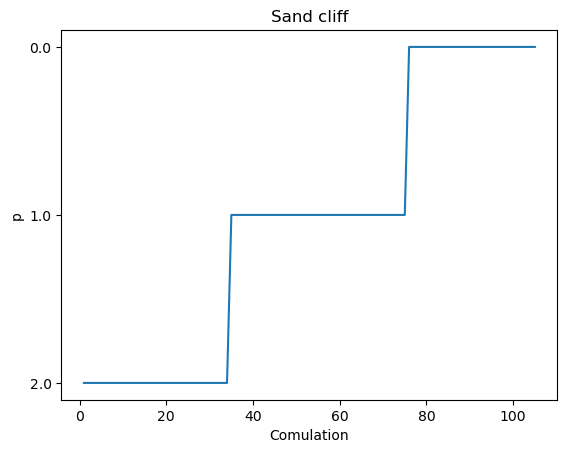

In [22]:
from matplotlib import pyplot as plt 

prob = sorted(
    # Extract 2nd column from array
    clasifyed_questions[:, 1],
    reverse=True)

x = np.arange(1,(len(prob)+1)) 
y = prob
plt.title("Sand cliff") 
plt.xlabel("Comulation") 
plt.ylabel("p")
plt.plot(x,y) 
plt.show()

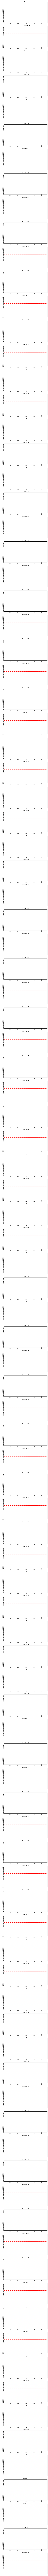

In [23]:
# And from categories perespective
data = clasifyed_questions

# Extract unique categories from the 1st column
categories = np.unique(data[:, 0])

# Create subplots for each category
fig, axs = plt.subplots(len(categories), 1, figsize=(8, 4 * len(categories)))

# Iterate through categories and plot corresponding values from the 2nd column
for i, category in enumerate(categories):
    # build x-axis dataset and sort it max->min
    subset_data = sorted(
        data[data[:, 0] == category][:, 1].astype(float),
        reverse=True
    )

    # build a plot
    axs[i].plot(range(len(subset_data)), subset_data, color='blue')

    # Set Y-axis scale from 0 to 1
    axs[i].set_ylim(0, 1)

    # Set Y-axis ticks every 0.05
    axs[i].set_yticks(np.arange(0, 1, 0.05))

    # Add a threshold line at y=0.65
    axs[i].axhline(y=0.65, color='red', linestyle='--', label='0.65 threshold')
    
    # set names of the axis
    axs[i].set_title(f'Category: {category}')
    axs[i].set_ylabel('p')



# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
#let's build array message.ID + Topic + Probability
questions_ID = query_result[:, 0]
questions_ID = questions_ID.reshape(-1, 1)
clasifyed_questions = np.hstack((questions_ID, clasifyed_questions))

In [21]:
update_db = Falce
if update_db == True:
    #SQL query 
    query = sql.SQL("INSERT INTO questions_tipics (message_ID, category, Probability) VALUES (%s, %s, %s)")

    # Execute the query
    connection = psycopg2.connect(**db_config)
    cursor = connection.cursor()
    cursor.executemany(query,clasifyed_questions)

    # Commit the transaction
    connection.commit()

    # Close the cursor and connection
    cursor.close()
    connection.close()
